In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyneb as pn

In [2]:
O3 = pn.Atom('O', 3, NLevels=5)
N2 = pn.Atom('N', 2, NLevels=5)
O2 = pn.Atom('O', 2, NLevels=5)
S2 = pn.Atom('S', 2, NLevels=5)

# ABUNDANCES DERIVATIONS WITH THE DIRECT METHOD

Atom class has the getIonAbundance method to determine ionic abundance from Te, Ne and a line intensity (normalised to Hbeta).

In [3]:
print(12 + np.log10(O3.getIonAbundance(int_ratio=125., tem=1e4, den=1e2, wave=5007, Hbeta=100.0)))

7.644872184321936


Let's see the effects of the line intensity, Te and Ne on the determined abundances

In [4]:
def print_abO(tem = 1e4, den = 1e2, int_ratio = 125., Hbeta = 100.):
    print('Te = {:6.0f}, Ne = {:6.0f}, [OIII]/Hb = {:5.2f} -> 12 + log(O++/H+) = {:.2f}'.format(tem, den, int_ratio/Hbeta, 
                                                                      12 + np.log10(O3.getIonAbundance(int_ratio=int_ratio, 
                                                                                                       tem=tem, den=den, 
                                                                                                       wave=5007, 
                                                                                                       Hbeta=Hbeta))))
print_abO(tem = 1e4, den = 1e2, int_ratio = 125.)
print_abO(tem = 1e4, den = 1e2, int_ratio = 155.)
print_abO(tem = 1.3e4, den = 1e2, int_ratio = 125.)
print_abO(tem = 1e4, den = 1e5, int_ratio = 125.)

Te =  10000, Ne =    100, [OIII]/Hb =  1.25 -> 12 + log(O++/H+) = 7.64
Te =  10000, Ne =    100, [OIII]/Hb =  1.55 -> 12 + log(O++/H+) = 7.74
Te =  13000, Ne =    100, [OIII]/Hb =  1.25 -> 12 + log(O++/H+) = 7.29
Te =  10000, Ne = 100000, [OIII]/Hb =  1.25 -> 12 + log(O++/H+) = 7.69


## Let's make the process more efficient

Te and Ne are determined, for different regions of the nebula, corresponding to different ions identified by their ionization potentials. It is now possible to determine the ionic abundances that corresponds to each observed emission line.

In [5]:
# Fill the following with values determined in the previous notebook (or whatever value you want)
dens = 4600
T_N2 = 12800.
T_O3 = 11927. 

In [6]:
%%writefile observations2.dat
LINE   MYOBJECT errMYOBJECT
S4_10.5m   7.00  0.25
Ne2_12.8m  8.30  0.25
Ne3_15.6m 34.10  0.20
S3_18.7m  10.00  0.20
O2_3726A  39.70  0.05
O2_3729A  18.60  0.05
Ne3_3869A 18.90  0.05
Ne3_3968A  6.4   0.10
S2_4069A   0.85  0.15
S2_4076A   0.45  0.15
O3_4363A   4.36  0.10
H1r_4861A 100.0  0.00
O3_5007A 435.09  0.05
N2_5755A   0.51  0.15
S3_6312A   0.76  0.15
O1_6300A   1.69  0.15
O1_6364A   0.54  0.15
N2_6548A   6.84  0.10
H1r_6563A 345.0  0.05
N2_6584A  19.00  0.10
S2_6716A   1.22  0.15
S2_6731A   2.18  0.15
Ar3_7136A  4.91  0.15
O2_7319A+  6.54  0.10
O2_7330A+  5.17  0.10

Overwriting observations2.dat


In [7]:
obs = pn.Observation('observations1.dat', fileFormat='lines_in_rows_err_cols', corrected=False) 
obs.extinction.law = 'CCM89'  # define the extinction law from Cardelli et al.
obs.def_EBV(label1="H1r_6563A", label2="H1r_4861A", r_theo=2.85) # Compute the redenning correction
obs.correctData(normWave=4861)                      # Correct the data from attenuation

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:4455: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data_tab = np.genfromtxt(obsFile, dtype=None, delimiter=delimiter, names=True)


In [8]:
obs.getUniqueAtoms()

array(['Ar3', 'H1r', 'N2', 'Ne2', 'Ne3', 'O1', 'O2', 'O3', 'S2', 'S3',
       'S4'], dtype='<U3')

In [9]:
all_atoms = pn.getAtomDict(atom_list=obs.getUniqueAtoms(), NLevels=5)

warng _ManageAtomicData: atom data not available for H1
warng _ManageAtomicData: coll data not available for H1


In [10]:
all_atoms

{'Ar3': Atom Ar3 from ar_iii_atom_MB09.dat and ar_iii_coll_MB09.dat,
 'N2': Atom N2 from n_ii_atom_FFT04.dat and n_ii_coll_T11.dat,
 'Ne2': Atom Ne2 from ne_ii_atom_Bal06.dat and ne_ii_coll_GMB01.dat,
 'Ne3': Atom Ne3 from ne_iii_atom_GMZ97.dat and ne_iii_coll_McLB00.dat,
 'O1': Atom O1 from o_i_atom_WFD96.dat and o_i_coll_BK95.dat,
 'O2': Atom O2 from o_ii_atom_FFT04.dat and o_ii_coll_Kal09.dat,
 'O3': Atom O3 from o_iii_atom_FFT04-SZ00.dat and o_iii_coll_SSB14.dat,
 'S2': Atom S2 from s_ii_atom_PKW09.dat and s_ii_coll_TZ10.dat,
 'S3': Atom S3 from s_iii_atom_PKW09.dat and s_iii_coll_TG99.dat,
 'S4': Atom S4 from s_iv_atom_JKD86-DHKD82.dat and s_iv_coll_DHKD82.dat}

In [11]:
# define a dictionary for the ionic abundances
ab_dic = {}
# we  use the following lines to determine the ionic abundances
ab_labels = ['N2_6584A', 'N2_6548A', 'N2_5755A', 'N3_57.4m', 'N4_1487A', 
             'O2_3726A', 'O2_3729A', 'O3_5007A', 'O3_4363A', 'O4_25.9m',
             'Ne2_12.8m', 'Ne3_3869A', 'Ne3_3968A', 'Ne3_15.6m', 'Ne5_3426A', 'Ne6_7.6m',
             'S2_4069A', 'S2_4076A', 'S2_6716A', 'S2_6731A', 'S3_6312A',
             'Ar3_7136A']
IP_cut = 30.
# loop on the observed lines to determine the corresponding ionic abundances
for line in obs.getSortedLines():
    # this is one way to define temp and dens in each zone
    # must be adapted to each case
    if (line.atom in all_atoms) and (line.label in ab_labels):
        if all_atoms[line.atom].IP > IP_cut:
            temp = T_O3
            IP_used = 'H'
        else:
            temp = T_N2
            IP_used = 'L'                 
        ab = all_atoms[line.atom].getIonAbundance(line.corrIntens, temp, dens, 
                                                  to_eval=line.to_eval, 
                                                  Hbeta=100)[0]
        print('{0:10s}  {1}   {2:6.3f}'.format(line.label, IP_used, ab * 1e6))
        # More than one abundance per ion can be obtained:
        if line.atom not in ab_dic:
            ab_dic[line.atom] = []
        ab_dic[line.atom].append(ab)

Ar3_7136A   L    0.187
N2_5755A    L    1.855
N2_6548A    L    1.962
N2_6584A    L    1.846
Ne2_12.8m   L    5.055
Ne3_15.6m   H   11.084
Ne3_3869A   H   12.644
Ne3_3968A   H   13.992
O2_3726A    L   17.752
O2_3729A    L   15.456
O3_4363A    H   83.693
O3_5007A    H   83.718
S2_4069A    L    0.123
S2_4076A    L    0.203
S2_6716A    L    0.078
S2_6731A    L    0.078
S3_6312A    L    0.535


What is the reason for abundances to differ for a given ion?

How could you "make" all the abundances for a given ion to agree? Is this the right way? ;-)

In [12]:
ab_dic

{'Ar3': [1.8667713916845278e-07],
 'N2': [1.8550519076697855e-06,
  1.9616420611577844e-06,
  1.8463752931620493e-06],
 'Ne2': [5.055065356847236e-06],
 'Ne3': [1.1084335685465835e-05,
  1.2644253777845992e-05,
  1.3991820434394754e-05],
 'O2': [1.7751976407676314e-05, 1.5456295687858322e-05],
 'O3': [8.369281763715053e-05, 8.371816771890296e-05],
 'S2': [1.2325625970957794e-07,
  2.0279358435826837e-07,
  7.77208599633049e-08,
  7.801611158451579e-08],
 'S3': [5.347203668158334e-07]}

How will you define the "adopted" abundance for each ion?

In [13]:
for atom in ab_dic:
    mean = np.mean(np.asarray(ab_dic[atom]))
    ab_dic[atom] = mean # It may NOT be the best way
ab_dic

{'Ar3': 1.8667713916845278e-07,
 'N2': 1.8876897539965397e-06,
 'Ne2': 5.055065356847236e-06,
 'Ne3': 1.2573469965902194e-05,
 'O2': 1.6604136047767316e-05,
 'O3': 8.370549267802674e-05,
 'S2': 1.2044670390391674e-07,
 'S3': 5.347203668158334e-07}

## Compute the total abundances from the ionic abundances

$$ \frac{X}{H} = \sum_i \frac{X^i}{H^+} $$

If all the ions are observed, the situation is simple.

This is not always the case, for example $N^{++}$ has no observable line in the visible.

Considere that the IPs of N and O are close:

In [14]:
pn.print_IPs(N_elems=8, N_ions=2)

H      13.60
He     24.59  54.42
Li      5.39  75.64
Be      9.32  18.21
B       8.30  25.15
C      11.26  24.38
N      14.53  29.60
O      13.62  35.12


One can pretend that the ionization of both atoms are also similar: $N^+/N = O^+/O$. 

This leads to: $$ \frac{N}{H} = \frac{N^+}{H^+} . \frac{N}{N^+} . \frac{H^+}{H} = \frac{N^+}{H^+} . \frac{O}{O^+} = \frac{N^+}{H^+} . ICF(N^+) $$

The ICF is the coefficient by which one ionic abundance (or the sum of the observed ionic abundances) of an element is multiplied to obtain the total (elemental) abundance.

In [15]:
# Instantiation of the ICF object
icf = pn.ICF()

In [16]:
# The name of the ICF is related to the paper and the equation in the paper. It is used to obtain an elemental abundance, from the sum of some ionic abundances.
icf.printAllICFs()

direct_He.23: elem = He; atom = He2 + He3; type = All
direct_N.23: elem = N; atom = N2 + N3; type = All
direct_N.234: elem = N; atom = N2 + N3 + N4; type = All
direct_N.2345: elem = N; atom = N2 + N3 + N4 + N5; type = All
direct_O.23: elem = O; atom = O2 + O3; type = All
direct_O.234: elem = O; atom = O2 + O3 + O4; type = All
direct_O.2345: elem = O; atom = O2 + O3 + O4 + O5; type = All
direct_S.23: elem = S; atom = S2 + S3; type = All
direct_S.234: elem = S; atom = S2 + S3 + S4; type = All
direct_S.2345: elem = S; atom = S2 + S3 + S4 + S5; type = All
direct_Ne.23: elem = Ne; atom = Ne2 + Ne3; type = All
direct_Ne.235: elem = Ne; atom = Ne2 + Ne3 + Ne5; type = All
direct_Ne.2345: elem = Ne; atom = Ne2 + Ne3 + Ne4 + Ne5; type = All
direct_Ne.345: elem = Ne; atom = Ne3 + Ne4 + Ne5; type = All
direct_Ne.2356: elem = Ne; atom = Ne2 + Ne3 + Ne5 + Ne6; type = All
direct_Mg.45: elem = Mg; atom = Mg4 + Mg5; type = All
direct_Ar.23: elem = Ar; atom = Ar2 + Ar3; type = All
direct_Ar.234: elem = 

In [17]:
# ICFs are from papers:
for type_ in icf.all_icf_refs:
    print(type_, icf.all_icf_refs[type_])

direct {'ref': 'Direct determination by summing observed ions', 'url': ''}
TPP77 {'ref': 'Torres-Peimbert and Peimbert 1977, RMAA, 2, 181', 'url': 'http://adsabs.harvard.edu/abs/1977RMxAA...2..181T'}
PHCD07 {'ref': 'Perez-Montero, Haegele, Contini, and Diaz 2007, MNRAS, 381, 125', 'url': 'http://adsabs.harvard.edu/abs/2007MNRAS.381..125P'}
KB94 {'ref': 'Kinsburgh & Barlow 1994, MNRAS, 271, 257', 'url': 'http://adsabs.harvard.edu/abs/1994MNRAS.271..257K'}
KH01 {'ref': 'Kwitter & Henry 2001, ApJ, 562, 804', 'url': 'http://adsabs.harvard.edu/abs/2001ApJ...562..804K'}
ITL94 {'ref': 'Izotov, Thuan & Lipovetsky 1994, ApJ, 435, 647', 'url': 'http://http://adsabs.harvard.edu/abs/1994ApJ...435..647I'}
Ial06 {'ref': 'Izotov et al 2006, A&A, 448, 955', 'url': 'http://adsabs.harvard.edu/abs/2006A%26A...448..955I'}
PC69 {'ref': 'Peimbert & Costero 1969, BOTT, 5, 3', 'url': 'http://adsabs.harvard.edu/abs/1969BOTT....5....3P'}
S78 {'ref': 'Stasinska 1978, A&A, 66, 257', 'url': 'http://adsabs.harvard.

In [18]:
# And they apply to different regions: HII, PNe, both.
icf.getAvailableICFs(type_= ('HII', 'All'))

{'Ar': ['direct_Ar.23',
  'direct_Ar.234',
  'direct_Ar.345',
  'PHCD07_16',
  'PHCD07_17',
  'ITL94_19',
  'ITL94_20',
  'Ial06_22a',
  'Ial06_22b',
  'Ial06_22c',
  'Ial06_23a',
  'Ial06_23b',
  'Ial06_23c'],
 'Cl': ['direct_Cl.23',
  'direct_Cl.34',
  'direct_Cl.234',
  'Ial06_21a',
  'Ial06_21b',
  'Ial06_21c'],
 'Fe': ['RR05_2', 'RR05_3', 'RR05_4', 'Ial06_24a', 'Ial06_24b', 'Ial06_24c'],
 'He': ['direct_He.23', 'PTPR92_21'],
 'Mg': ['direct_Mg.45'],
 'N': ['direct_N.23',
  'direct_N.234',
  'direct_N.2345',
  'Ial06_18a',
  'Ial06_18b',
  'Ial06_18c'],
 'Ne': ['direct_Ne.23',
  'direct_Ne.235',
  'direct_Ne.2345',
  'direct_Ne.345',
  'direct_Ne.2356',
  'PHCD07_12',
  'PHCD07_13',
  'PC69_40',
  'S78_265b',
  'Ial06_19a',
  'Ial06_19b',
  'Ial06_19c'],
 'O': ['direct_O.23', 'direct_O.234', 'direct_O.2345', 'Ial06_16', 'Ial06_17'],
 'S': ['direct_S.23',
  'direct_S.234',
  'direct_S.2345',
  'Ial06_20a',
  'Ial06_20b',
  'Ial06_20c']}

In [19]:
# Some ICFs requiere the He ionic fracions. In lack of HeII line, we put He++ abundance to a very low value
ab_dic['He1r'] = 0.1
ab_dic['He2r'] = 0.00001
# Computing the elemental abundances from all ICF rules.

# The following computes the elemental abundances from the rules.

def pretty_print_icf(icf=None, icf_family='direct'):
    if icf is None:
        icf = pn.ICF()
    elem_abun = icf.getElemAbundance(ab_dic, icf_family=icf_family)
    printRule = True
    for icf_ref in np.sort(list(elem_abun.keys())):
        if np.isfinite(elem_abun[icf_ref]) and np.log10(elem_abun[icf_ref]).all() > -10:
            if printRule:
                print('{0:12s} {1:2s} = {3:5.2f} using {2}'.format(icf_ref, 
                                                  icf.all_icfs[icf_ref]['elem'],
                                                  icf.getExpression(icf_ref), 
                                                  np.log10(elem_abun[icf_ref])+12))
            else:
                print('{0:12s} {1}={2:.3}'.format(icf_ref, 
                                                  icf.all_icfs[icf_ref]['elem'],
                                                  np.log10(elem_abun[icf_ref])+12))


In [20]:
pretty_print_icf()

direct_He.23 He = 11.00 using He = He2 + He3
direct_Ne.23 Ne =  7.25 using Ne = Ne2 + Ne3
direct_O.23  O  =  8.00 using O = O2 + O3
direct_S.23  S  =  5.82 using S = S2 + S3


In [21]:
pretty_print_icf(icf, 'PHCD07')

PHCD07_12    Ne =  7.18 using Ne = (Ne3) * (O2 + O3) / O3
PHCD07_13    Ne =  7.13 using Ne = (Ne3) * (0.753 + 0.142 * O3 / (O2 + O3) + 0.171 / O3 * (O2 + O3))
PHCD07_17    Ar =  5.36 using Ar = (Ar3) * (0.596 + 0.967 * (1 - O3 / (O2 + O3)) + 0.077 / (1 - O3 / (O2 + O3)))


In [22]:
pretty_print_icf(icf, 'Ial06')

Ial06_16     O  =  8.00 using O = O2 + O3
Ial06_17     O  =  8.00 using O = (O2 + O3) * 1 + 0.5 * He3 / (He2 + He3)
Ial06_18a    N  =  7.03 using N = (N2) * (-0.825 * O2 / (O2 + O3) + 0.718 + 0.853 * (O2 + O3) / O2)
Ial06_18b    N  =  7.03 using N = (N2) * (-0.809 * O2 / (O2 + O3) + 0.712 + 0.852 * (O2 + O3) / O2)
Ial06_18c    N  =  7.03 using N = (N2) * (-1.476 * O2 / (O2 + O3) + 1.752 + 0.688 * (O2 + O3) / O2)
Ial06_19a    Ne =  7.13 using Ne = (Ne3) * (-0.385 * O3 / (O2 + O3) + 1.365 + 0.022 * (O2 + O3) / O3)
Ial06_19b    Ne =  7.13 using Ne = (Ne3) * (-0.405 * O3 / (O2 + O3) + 1.382 + 0.021 * (O2 + O3) / O3)
Ial06_19c    Ne =  7.14 using Ne = (Ne3) * (-0.591 * O3 / (O2 + O3) + 0.927 + 0.546 * (O2 + O3) / O3)
Ial06_20a    S  =  5.99 using S = ((S2 + S3)) * (0.121 * O2 / (O2 + O3) + 0.511 + 0.161 * (O2 + O3) / O2)
Ial06_20b    S  =  5.91 using S = ((S2 + S3)) * (0.155 * O2 / (O2 + O3) + 0.849 + 0.062 * (O2 + O3) / O2)
Ial06_20c    S  =  6.01 using S = ((S2 + S3)) * (0.178 * O2 / (O2 

### !!! the following ones are for PNe !!!

In [23]:
pretty_print_icf(icf, 'KB94')

KB94_A1.10   N  =  7.06 using N = (N2) * KB94_A10  / O2
KB94_A1.10b  N  =  7.06 using N = (N2) * KB94_A10b  / O2
KB94_A10     O  =  8.00 using O = (O2 + O3) * ((He2 + He3) / He2)**(2./3.)
KB94_A10b    O  =  8.00 using O = O2 + O3
KB94_A28.10  Ne =  7.18 using Ne = (Ne3) * KB94_A10  / O3
KB94_A28.10b Ne =  7.18 using Ne = (Ne3) * KB94_A10b  / O3
KB94_A32     Ar =  5.54 using Ar = (Ar3) * 1.87
KB94_A36.10  S  =  5.94 using S = (S2 + S3) *  (1-(1 - O2/KB94_A10)**3)**(-1./3.)
KB94_A36.10b S  =  5.94 using S = (S2 + S3) *  (1-(1 - O2/KB94_A10b)**3)**(-1./3.)


## Monte Carlo

In [24]:
np.random.seed(42)
N_MC = 5000 # Take care, 500 needs more then 5 minutes to compute
#pn.config.use_multiprocs() # This does not work well from within a Notebooks. But in scripts from termiinal it seems OK.
obs = pn.Observation('observations1.dat', fileFormat='lines_in_rows_err_cols', corrected=False)
obs.addMonteCarloObs(N_MC)
obs.extinction.law = 'CCM89'  # define the extinction law from Cardelli et al.
obs.def_EBV(label1="H1r_6563A", label2="H1r_4861A", r_theo=2.85) # Compute the redenning correction
obs.correctData(normWave=4861)

In [25]:
obs.lineLabels

array(['S4_10.5m', 'Ne2_12.8m', 'Ne3_15.6m', 'S3_18.7m', 'O2_3726A',
       'O2_3729A', 'Ne3_3869A', 'Ne3_3968A', 'S2_4069A', 'S2_4076A',
       'O3_4363A', 'H1r_4861A', 'O3_5007A', 'N2_5755A', 'S3_6312A',
       'O1_6300A', 'O1_6364A', 'N2_6548A', 'H1r_6563A', 'N2_6584A',
       'S2_6716A', 'S2_6731A', 'Ar3_7136A', 'O2_7319A+', 'O2_7330A+'],
      dtype='<U9')

In [26]:
obs.extinction.cHbeta[0:10]

array([0.27875894, 0.21096549, 0.25662566, 0.30490549, 0.25465721,
       0.3598357 , 0.29216664, 0.26074655, 0.18492563, 0.24291375])

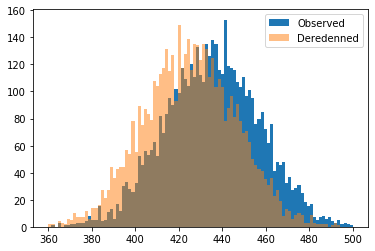

In [27]:
f, ax = plt.subplots()
ax.hist(obs.getIntens(returnObs=True)['O3_5007A'], bins=np.linspace(360, 500, 100), label='Observed');
ax.hist(obs.getIntens()['O3_5007A'], bins=np.linspace(360, 500, 100), alpha=0.5,label='Deredenned')
ax.legend();

In [28]:
diags = pn.Diagnostics()
diags.addDiagsFromObs(obs)

warng Observation: No line for O2_3727A+ from NoneNone at wavelength None (blend=False)


In [29]:
pn.log_.timer('Start', quiet=True, calling='Computing Te Ne')
T_O3, dens_S2 = diags.getCrossTemDen(diag_tem='[OIII] 4363/5007', diag_den='[SII] 6731/6716', obs=obs)
T_N2, dens_O2 = diags.getCrossTemDen(diag_tem='[NII] 5755/6584', diag_den='[OII] 3726/3729', obs=obs)
pn.log_.timer('End')

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:833: RuntimeWarning: invalid value encountered in greater
  no_conv = ((abs(den_old - den) / den * 100) > tol_den) | ((abs(tem_old - tem) / tem * 100) > tol_tem)


   None: End in 260.869656085968


In [30]:
dens = np.nanmean(np.array((dens_S2, dens_O2)), axis=0)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


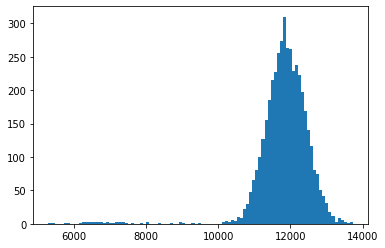

In [31]:
f, ax = plt.subplots()
ax.hist(T_O3, bins=100);

## A very experimental way to determine Te and Ne is using a Neural Network. It is still in development, but very promising. Contact me if you have huge number of data to deal with.

In [32]:
try:
    from ai4neb import manage_RM
except:
    !pip install -U git+https://github.com/morisset/AI4neb.git
    from ai4neb import manage_RM

In [33]:
# This transmits the random seed to the ANN
diags.ANN_inst_kwargs['random_seed'] = 42

In [34]:
pn.atomicData.resetDataFileDict()

In [35]:
pn.log_.timer('Start', quiet=True, calling='Computing Te Ne with ANN')
T_O3ANN, dens_S2ANN = diags.getCrossTemDen(diag_tem='[OIII] 4363/5007', diag_den='[SII] 6731/6716', obs=obs, 
                                           use_ANN=True, limit_res=True, start_tem=3e3, end_den=1e6)
T_N2ANN, dens_O2ANN = diags.getCrossTemDen(diag_tem='[NII] 5755/6584', diag_den='[OII] 3726/3729', obs=obs, 
                                           use_ANN=True, limit_res=True, start_tem=3e3, end_den=1e6)
pn.log_.timer('End')

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


   None: End in 21.26448893547058


In [36]:
densANN = np.nanmean(np.array((dens_S2ANN, dens_O2ANN)), axis=0)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


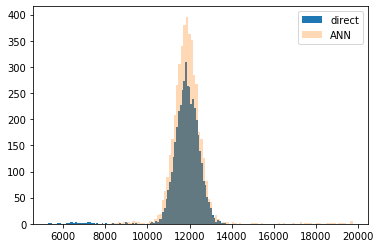

In [37]:
f, ax = plt.subplots()
ax.hist(T_O3, bins=100, label='direct')
ax.hist(T_O3ANN, bins=100, alpha=0.3, label='ANN')
ax.legend();

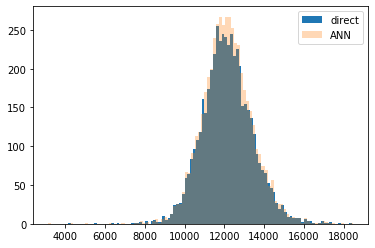

In [38]:
f, ax = plt.subplots()
ax.hist(T_N2, bins=100, label='direct')
ax.hist(T_N2ANN, bins=100, alpha=0.3, label='ANN')
ax.legend();

In [39]:
print('T[NII]      = {:.0f} +/- {:.0f}'.format(np.nanmedian(T_N2), np.nanstd(T_N2)))
print('T[NII]  ANN = {:.0f} +/- {:.0f}'.format(np.nanmedian(T_N2ANN), np.nanstd(T_N2ANN)))
print('T[OIII]     = {:.0f} +/- {:.0f}'.format(np.nanmedian(T_O3), np.nanstd(T_O3)))
print('T[OIII] ANN = {:.0f} +/- {:.0f}'.format(np.nanmedian(T_O3ANN), np.nanstd(T_O3ANN)))

T[NII]      = 12102 +/- 1260
T[NII]  ANN = 12124 +/- 1255
T[OIII]     = 11873 +/- 723
T[OIII] ANN = 11862 +/- 793


In [40]:
# define a dictionary for the ionic abundances
ab_dic = {}
ab_dicANN = {}
# we  use the following lines to determine the ionic abundances
ab_labels = ['N2_6584A', 'N3_57.4m', 'N4_1487A', 
             'O2_3726A', 'O2_3729A', 'O3_5007A', 'O4_25.9m',
             'Ne2_12.8m', 'Ne3_3869A', 
             'S2_6716A', 'S2_6731A','S3_6312A',
             'Ar3_7136A']
IP_cut = 30. 
# loop on the observed lines to determine the corresponding ionic abundances
for line in obs.getSortedLines():
    # this is one way to define temp and dens in each zone
    # must be adapted to each case
    if (line.atom in all_atoms) and (line.label in ab_labels):
        if all_atoms[line.atom].IP > IP_cut:
            temp = T_O3
            tempANN = T_O3ANN
            IP_used = 'H'
        else:
            temp = T_N2
            tempANN = T_N2ANN
            IP_used = 'L'                 
        ab = all_atoms[line.atom].getIonAbundance(line.corrIntens, temp, dens, 
                                                  to_eval=line.to_eval, 
                                                  Hbeta=100)
        abANN = all_atoms[line.atom].getIonAbundance(line.corrIntens, tempANN, densANN, 
                                                  to_eval=line.to_eval, 
                                                  Hbeta=100)
        # More than one abundance per ion can be obtained:
        if line.atom not in ab_dic:
            ab_dic[line.atom] = []
        if line.atom not in ab_dicANN:
            ab_dicANN[line.atom] = []
        ab_dic[line.atom].append(ab)
        ab_dicANN[line.atom].append(abANN)

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:3591: RuntimeWarning: invalid value encountered in less
  tt = (logd < log_dens_min)
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:3597: RuntimeWarning: invalid value encountered in greater
  tt = (logd > log_dens_max)
/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/pynebcore.py:3606: RuntimeWarning: invalid value encountered in less
  if (temg < temp_min).sum() != 0 and self.extrapolate:


In [41]:
len(ab_dic['S2'])

2

In [42]:
print(np.nanmedian(np.log10(ab_dic['S2']), axis=1))
print(np.nanmedian(np.log10(ab_dicANN['S2']), axis=1))

[-6.93934491 -6.96760932]
[-6.93542577 -6.96733804]


In [43]:
for ion in ab_dic:
    ab_dic[ion] = np.nanmedian(ab_dic[ion], axis=0)
for ion in ab_dicANN:
    ab_dicANN[ion] = np.nanmedian(ab_dicANN[ion], axis=0)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [44]:
ab_dic['He1r'] = 0.1 * np.ones_like(ab_dic['O2']) + np.random.randn(N_MC+1) * 0.005
ab_dic['He2r'] = 0.00001 * np.ones_like(ab_dic['O2'])
ab_dicANN['He1r'] = 0.1 * np.ones_like(ab_dicANN['O2']) + np.random.randn(N_MC+1) * 0.005
ab_dicANN['He2r'] = 0.00001 * np.ones_like(ab_dicANN['O2'])

In [45]:
icf = pn.ICF()

In [46]:
elem_abun = icf.getElemAbundance(ab_dic, icf_family='Ial06', use_MC=True)
elem_abunANN = icf.getElemAbundance(ab_dicANN, icf_family='Ial06', use_MC=True)

In [47]:
from pyneb.utils.misc import get_reduced_dic

In [60]:
help(get_reduced_dic)

Help on function get_reduced_dic in module pyneb.utils.misc:

get_reduced_dic(N_rand, n_obs_ori, dic, value_method='original', error_method='std', abund12=False)
    This function returns a dictionary of values (ionic or atomic abundances, temp...) and errors.
    It takes as argument a dictionary that is supposed to contains n_obs_ori values from
        the original observations, followed (optionaly) by N_rand*n_obs_ori MonteCarlo values.
    The new values are computed by returning the original value (default), the mean or the median, 
        depending on "value_method"
    The errors are computed by 68% quantiles or standart deviation (Default), depending on on "error_method"
    
    It also transforms the abundances by number into 12+log10(abundances by number)



In [61]:
elem_abun2 = get_reduced_dic(N_MC, obs.n_obs_origin, elem_abun, value_method='median', error_method='quants', abund12=True)   
elem_abun2ANN = get_reduced_dic(N_MC, obs.n_obs_origin, elem_abunANN, value_method='median', error_method='quants', abund12=True)    

In [65]:
for icf_ref in np.sort(list(elem_abun2.keys())):
    if icf_ref[-1] != 'e':
        if np.log10(elem_abun2[icf_ref]) > -10:
            value = elem_abun2[icf_ref][0]
            err = elem_abun2[icf_ref+'_e'][0]
            print('  {:10s} {:2s} = {:4.3f} +/- {:4.2f} using {}'.format(icf_ref, 
                                              icf.all_icfs[icf_ref]['elem'],
                                                value,
                                                err      ,    
                                              icf.getExpression(icf_ref), 
                                              ))
            value = elem_abun2ANN[icf_ref][0]
            err = elem_abun2ANN[icf_ref+'_e'][0]
            print('ANN{:10s} {:2s} = {:4.3f} +/- {:4.2f} using {}'.format(icf_ref, 
                                              icf.all_icfs[icf_ref]['elem'],
                                                value,
                                                err      ,    
                                              icf.getExpression(icf_ref), 
                                              ))


  Ial06_16   O  = 8.050 +/- 0.08 using O = O2 + O3
ANNIal06_16   O  = 8.052 +/- 0.08 using O = O2 + O3
  Ial06_17   O  = 8.050 +/- 0.08 using O = (O2 + O3) * 1 + 0.5 * He3 / (He2 + He3)
ANNIal06_17   O  = 8.052 +/- 0.08 using O = (O2 + O3) * 1 + 0.5 * He3 / (He2 + He3)
  Ial06_18a  N  = 6.970 +/- 0.09 using N = (N2) * (-0.825 * O2 / (O2 + O3) + 0.718 + 0.853 * (O2 + O3) / O2)
ANNIal06_18a  N  = 6.968 +/- 0.10 using N = (N2) * (-0.825 * O2 / (O2 + O3) + 0.718 + 0.853 * (O2 + O3) / O2)
  Ial06_18b  N  = 6.969 +/- 0.09 using N = (N2) * (-0.809 * O2 / (O2 + O3) + 0.712 + 0.852 * (O2 + O3) / O2)
ANNIal06_18b  N  = 6.968 +/- 0.10 using N = (N2) * (-0.809 * O2 / (O2 + O3) + 0.712 + 0.852 * (O2 + O3) / O2)
  Ial06_18c  N  = 6.987 +/- 0.08 using N = (N2) * (-1.476 * O2 / (O2 + O3) + 1.752 + 0.688 * (O2 + O3) / O2)
ANNIal06_18c  N  = 6.985 +/- 0.09 using N = (N2) * (-1.476 * O2 / (O2 + O3) + 1.752 + 0.688 * (O2 + O3) / O2)
  Ial06_19a  Ne = 7.149 +/- 0.07 using Ne = (Ne3) * (-0.385 * O3 / (O2 + 

## Atomic data can be changed to see the effects on determining the abundances

In [51]:
pn.atomicData.setDataFile('o_iii_coll_MBZ20.dat')
pn.atomicData.setDataFile('n_ii_coll_MBZ20.dat')
diags2 = pn.Diagnostics()
diags2.addDiagsFromObs(obs)
# This transmits the random seed to the ANN
diags2.ANN_inst_kwargs['random_seed'] = 42
T_O3ANN2, dens_S2ANN2 = diags2.getCrossTemDen(diag_tem='[OIII] 4363/5007', diag_den='[SII] 6731/6716', obs=obs, 
                                           use_ANN=True, limit_res=True, start_tem=3e3, end_den=1e6)
T_N2ANN2, dens_O2ANN2 = diags2.getCrossTemDen(diag_tem='[NII] 5755/6584', diag_den='[OII] 3726/3729', obs=obs, 
                                           use_ANN=True, limit_res=True, start_tem=3e3, end_den=1e6)
densANN2 = np.nanmean(np.array((dens_S2ANN2, dens_O2ANN2)), axis=0)

In [68]:
print('    Te[NII] = {:.0f} +/- {:.0f}, Te[OIII] = {:.0f} +/- {:.0f}'.format(np.nanmean(T_N2ANN),
                                                                                                  np.nanstd(T_N2ANN),
                                                                                                  np.nanmedian(T_O3ANN),
                                                                                                  np.nanstd(T_O3ANN)))
print('Mao Te[NII] = {:.0f} +/- {:.0f}, Te[OIII] = {:.0f} +/- {:.0f}'.format(np.nanmean(T_N2ANN2),
                                                                                                  np.nanstd(T_N2ANN2),
                                                                                                  np.nanmedian(T_O3ANN2),
                                                                                                  np.nanstd(T_O3ANN2)))
print('')
# define a dictionary for the ionic abundances
ab_dicANN2 = {}
# we  use the following lines to determine the ionic abundances
ab_labels = ['N2_6584A', 'N3_57.4m', 'N4_1487A', 
             'O2_3726A', 'O2_3729A', 'O3_5007A', 'O4_25.9m',
             'Ne2_12.8m', 'Ne3_3869A', 
             'S2_6716A', 'S2_6731A','S3_6312A',
             'Ar3_7136A']
IP_cut = 30. 
# loop on the observed lines to determine the corresponding ionic abundances
for line in obs.getSortedLines():
    # this is one way to define temp and dens in each zone
    # must be adapted to each case
    if (line.atom in all_atoms) and (line.label in ab_labels):
        if all_atoms[line.atom].IP > IP_cut:
            tempANN2 = T_O3ANN2
            IP_used = 'H'
        else:
            tempANN2 = T_N2ANN2
            IP_used = 'L'                 
        abANN2 = all_atoms[line.atom].getIonAbundance(line.corrIntens, tempANN2, densANN2, 
                                                  to_eval=line.to_eval, 
                                                  Hbeta=100)
        # More than one abundance per ion can be obtained:
        if line.atom not in ab_dicANN2:
            ab_dicANN2[line.atom] = []
        ab_dicANN2[line.atom].append(abANN2)
for ion in ab_dicANN2:
    ab_dicANN2[ion] = np.nanmedian(ab_dicANN2[ion], axis=0)
ab_dicANN2['He1r'] = 0.1 * np.ones_like(ab_dicANN2['O2']) + np.random.randn(N_MC+1) * 0.005
ab_dicANN2['He2r'] = 0.00001 * np.ones_like(ab_dicANN2['O2'])
elem_abunANN2 = icf.getElemAbundance(ab_dicANN2, icf_family='Ial06', use_MC=True)
elem_abun2ANN2 = get_reduced_dic(N_MC, obs.n_obs_origin, elem_abunANN2, value_method='median', error_method='quants', abund12=True)
for icf_ref in np.sort(list(elem_abun2.keys())):
    if icf_ref[-1] != 'e':
        if np.log10(elem_abun2[icf_ref]) > -10:
            value = elem_abun2ANN[icf_ref][0]
            err = elem_abun2ANN[icf_ref+'_e'][0]
            print('   {:10s} {:2s} = {:4.2f} +/- {:4.2f} using {}'.format(icf_ref, 
                                              icf.all_icfs[icf_ref]['elem'],
                                                value,
                                                err      ,    
                                              icf.getExpression(icf_ref), 
                                              ))
            value = elem_abun2ANN2[icf_ref][0]
            err = elem_abun2ANN2[icf_ref+'_e'][0]
            print('Mao {:10s} {:2s} = {:4.2f} +/- {:4.2f} using {}'.format(icf_ref, 
                                              icf.all_icfs[icf_ref]['elem'],
                                                value,
                                                err      ,    
                                              icf.getExpression(icf_ref), 
                                              ))

    Te[NII] = 12160 +/- 1255, Te[OIII] = 11862 +/- 793
Mao Te[NII] = 11201 +/- 1078, Te[OIII] = 12691 +/- 1383

   Ial06_16   O  = 8.05 +/- 0.08 using O = O2 + O3
Mao Ial06_16   O  = 8.04 +/- 0.11 using O = O2 + O3
   Ial06_17   O  = 8.05 +/- 0.08 using O = (O2 + O3) * 1 + 0.5 * He3 / (He2 + He3)
Mao Ial06_17   O  = 8.04 +/- 0.11 using O = (O2 + O3) * 1 + 0.5 * He3 / (He2 + He3)
   Ial06_18a  N  = 6.97 +/- 0.10 using N = (N2) * (-0.825 * O2 / (O2 + O3) + 0.718 + 0.853 * (O2 + O3) / O2)
Mao Ial06_18a  N  = 6.90 +/- 0.09 using N = (N2) * (-0.825 * O2 / (O2 + O3) + 0.718 + 0.853 * (O2 + O3) / O2)
   Ial06_18b  N  = 6.97 +/- 0.10 using N = (N2) * (-0.809 * O2 / (O2 + O3) + 0.712 + 0.852 * (O2 + O3) / O2)
Mao Ial06_18b  N  = 6.90 +/- 0.09 using N = (N2) * (-0.809 * O2 / (O2 + O3) + 0.712 + 0.852 * (O2 + O3) / O2)
   Ial06_18c  N  = 6.99 +/- 0.09 using N = (N2) * (-1.476 * O2 / (O2 + O3) + 1.752 + 0.688 * (O2 + O3) / O2)
Mao Ial06_18c  N  = 6.95 +/- 0.09 using N = (N2) * (-1.476 * O2 / (O2 +

## The effect of changing atomic data is clear. It is not systematically in the same direction for all the element abundances, because the electron temperature decreases for N+ and increases for O++. 

## O/H is almost not affected N/H and Ne/H decrease while S/H and Ar/H increase, all by values close to 0.05 dex.